In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import malaya
import random
import re
import string
from pprint import pprint
from statistics import mean
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

sia = SentimentIntensityAnalyzer()
mly = malaya.sentiment.multinomial()

malay_stopwords = np.load('data/malay_stopwords.npy')
positive_malay_words = np.load('data/positive_malay_words.npy')
negative_malay_words = np.load('data/negative_malay_words.npy')

unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend(malay_stopwords)

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    #if tag.startswith("NN"):
        #return False
    if word in string.punctuation:
        return False
    return True

df = pd.read_csv('datasets/duck_training.csv')
df = df.replace(-1, 'negative')
df = df.replace(0, 'neutral')
df = df.replace(1, 'positive')
df = df[df['TweetSentiment'] != 'neutral']

df2 = pd.read_csv('datasets/student_tweet_training.csv')

df3 = pd.read_csv('datasets/malay_dataset_twitter_training.csv')
df3 = df3[df3['TweetSentiment'] != 'neutral']

dfs = [df, df2, df3]
df = pd.concat(dfs, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #shuffles the dataframe

tweets_df = df['TweetText']
positive_tweets = np.array(tweets_df[df['TweetSentiment'] == 'positive'])
negative_tweets = np.array(tweets_df[df['TweetSentiment'] == 'negative'])
tweets = np.concatenate((positive_tweets, negative_tweets))

positive_words = []
for positive_tweet in positive_tweets :
    #removes hyperlinks and twitter mentions
    positive_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', positive_tweet)
    positive_tweet = re.sub('(@[A-Za-z0-9_]+)','', positive_tweet)

    positive_tweet = positive_tweet.lower()
    positive_words.extend(nltk.pos_tag(nltk.word_tokenize(positive_tweet)))

positive_words_raw = [word for word, tag in positive_words]

positive_words = [word for word, tag in filter(
    skip_unwanted,
    positive_words)
]

negative_words = []
for negative_tweet in negative_tweets :
    #removes hyperlinks and twitter mentions
    negative_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', negative_tweet)
    negative_tweet = re.sub('(@[A-Za-z0-9_]+)','', negative_tweet)

    negative_tweet = negative_tweet.lower()
    negative_words.extend(nltk.pos_tag(nltk.word_tokenize(negative_tweet)))

negative_words_raw = [word for word, tag in negative_words]

negative_words = [word for word, tag in filter(
    skip_unwanted,
    negative_words)
]

positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)
common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]
    
positive_word_top_100 = [word for word, count in positive_fd.most_common(100)]
negative_word_top_100 = [word for word, count in negative_fd.most_common(100)]

learned_positive_words = [word for word in positive_fd]
learned_negative_words = [word for word in negative_fd]

#positive_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in positive_words_raw
    #if word.isalpha() and word not in unwanted
#])

#negative_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    #word for word in negative_words_raw
    #if word.isalpha() and word not in unwanted
#])

np.save('data/positive_word_top_100', positive_word_top_100)
np.save('data/negative_word_top_100', negative_word_top_100)
#np.save('data/learned_words', learned_words)
np.save('data/learned_positive_words', learned_positive_words)
np.save('data/learned_negative_words', learned_negative_words)

def get_features(tweet):
    features = dict()
    top_positive_words_frequency = 0
    top_negative_words_frequency = 0
    positive_malay_words_frequency = 0
    negative_malay_words_frequency = 0
    learned_positive_words_frequency = 0
    learned_negative_words_frequency = 0
    english_compound_scores = list()
    english_positive_scores = list()
    english_negative_scores = list()
    malaya_positive_scores = list()
    malaya_negative_scores = list()

    for sentence in nltk.sent_tokenize(tweet):
        #removes hyperlinks and twitter mentions
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sentence)
        sentence = re.sub('(@[A-Za-z0-9_]+)','', sentence)

        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_word_top_100:
                top_positive_words_frequency += 1
            if word.lower() in negative_word_top_100:
                top_negative_words_frequency += 1

            if word.lower() in positive_malay_words:
                positive_malay_words_frequency += 1
            if word.lower() in negative_malay_words:
                negative_malay_words_frequency += 1

            if word.lower() in learned_positive_words:
                learned_positive_words_frequency += 1
            if word.lower() in learned_negative_words:
                learned_negative_words_frequency += 1

        malaya_positive_scores.append(mly.predict_proba([sentence])[0]["positive"])
        malaya_negative_scores.append(mly.predict_proba([sentence])[0]["negative"])

        english_compound_scores.append(sia.polarity_scores(sentence)["compound"])
        english_positive_scores.append(sia.polarity_scores(sentence)["pos"])
        english_negative_scores.append(sia.polarity_scores(sentence)["neg"])

    features["malaya_mean_positive"] = mean(malaya_positive_scores)
    features["malaya_mean_negative"] = mean(malaya_negative_scores)
    
    features["english_mean_compound"] = mean(english_compound_scores) + 1
    features["english_mean_positive"] = mean(english_positive_scores)
    features["english_mean_negative"] = mean(english_negative_scores)
    
    features["top_positive_words_frequency"] = top_positive_words_frequency
    features["top_negative_words_frequency"] = top_negative_words_frequency

    features["positive_malay_words_frequency"] = positive_malay_words_frequency
    features["negative_malay_words_frequency"] = negative_malay_words_frequency

    features["learned_positive_words_frequency"] = learned_positive_words_frequency
    features["learned_negative_words_frequency"] = learned_negative_words_frequency

    return features

training_dataset = [
    (get_features(tweet), "positive")
    for tweet in positive_tweets
]
training_dataset.extend([
    (get_features(tweet), "negative")
    for tweet in negative_tweets
])

training_count = len(training_dataset) // 5
random.shuffle(training_dataset)

classifiers = {
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "SVMClassifier" : SVC(),
}

for classifier_name, sklearn_classifier in classifiers.items():
    classifier = nltk.classify.SklearnClassifier(sklearn_classifier)

    print(F"\nTraining {classifier_name} model...")
    print(F"Training sample size: {len(training_dataset)-training_count}")
    classifier.train(training_dataset[:len(training_dataset)-training_count])

    print(F"Testing {classifier_name} model...")
    print(F"Testing sample size: {training_count}")
    accuracy = nltk.classify.accuracy(classifier, training_dataset[len(training_dataset)-training_count:])

    print(F"{classifier_name} - Accuracy: {accuracy:.2%}")
    pickle.dump(classifier, open(F"models/{classifier_name}.pickle", 'wb'))

c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya_boilerplate\frozen_graph.py:35: UserWarning: Cannot import beam_search_ops from Tensorflow Addons, ['malaya.jawi_rumi.deep_model', 'malaya.phoneme.deep_model', 'malaya.rumi_jawi.deep_model', 'malaya.stem.deep_model'] will not available to use, make sure Tensorflow Addons version >= 0.12.0
  warnings.warn(
c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya_boilerplate\frozen_graph.py:38: UserWarning: check compatible Tensorflow version with Tensorflow Addons at https://github.com/tensorflow/addons/releases
  warnings.warn(
c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya\tokenizer.py:202: FutureWarning: Possible nested set at position 3361
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
c:\Users\User\anaconda3\envs\fyp3\lib\site-packages\malaya\tokenizer.py:202: FutureWarning: Possible nested set at position 3879
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))



Training MultinomialNB model...
Training sample size: 1414
Testing MultinomialNB model...
Testing sample size: 353
MultinomialNB - Accuracy: 95.47%

Training KNeighborsClassifier model...
Training sample size: 1414
Testing KNeighborsClassifier model...
Testing sample size: 353
KNeighborsClassifier - Accuracy: 95.75%

Training DecisionTreeClassifier model...
Training sample size: 1414
Testing DecisionTreeClassifier model...
Testing sample size: 353
DecisionTreeClassifier - Accuracy: 94.90%

Training RandomForestClassifier model...
Training sample size: 1414
Testing RandomForestClassifier model...
Testing sample size: 353
RandomForestClassifier - Accuracy: 95.47%

Training LogisticRegression model...
Training sample size: 1414
Testing LogisticRegression model...
Testing sample size: 353
LogisticRegression - Accuracy: 94.90%

Training MLPClassifier model...
Training sample size: 1414
Testing MLPClassifier model...
Testing sample size: 353
MLPClassifier - Accuracy: 95.18%

Training SVMCla

Multinomial NB 

Training Accuracy scores: [0.96673744 0.96178344 0.96463932 0.96676096 0.96463932]
Mean Training Accuracy: 96.4912096305172
Training Precision scores: [0.98302469 0.97836167 0.98       0.98305085 0.98148148]
Mean Training Precision: 0.9811837379079584
Training Recall scores: [0.94650817 0.94056464 0.94510386 0.94658754 0.94362018]
Mean Training Recall: 0.9444768762042497
Training F1 scores: [0.96442089 0.95909091 0.96223565 0.96447468 0.96217852]
Mean Training F1 Score: 0.9624801296117382
Validation Accuracy scores: [0.96045198 0.97740113 0.96600567 0.95750708 0.9631728 ]
Mean Validation Accuracy: 96.49077319505128
Validation Precision scores: [0.98136646 0.99386503 0.9875     0.96932515 0.97546012]
Mean Validation Precision: 0.981503353275159
Validation Recall scores: [0.93491124 0.95857988 0.94047619 0.94047619 0.94642857]
Mean Validation Recall: 0.9441744153282615
Validation F1 scores: [0.95757576 0.97590361 0.96341463 0.95468278 0.96072508]
Mean Validation F1 Score

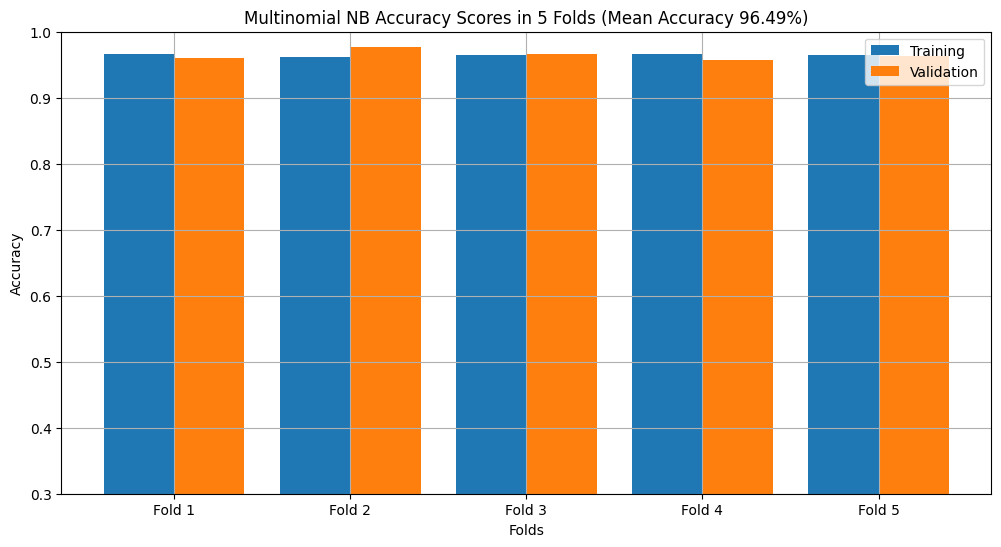

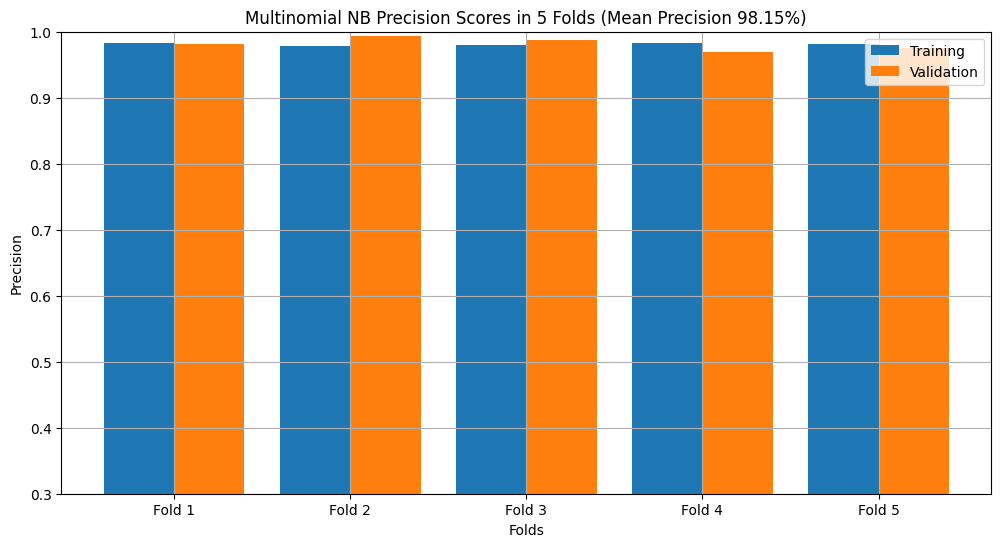

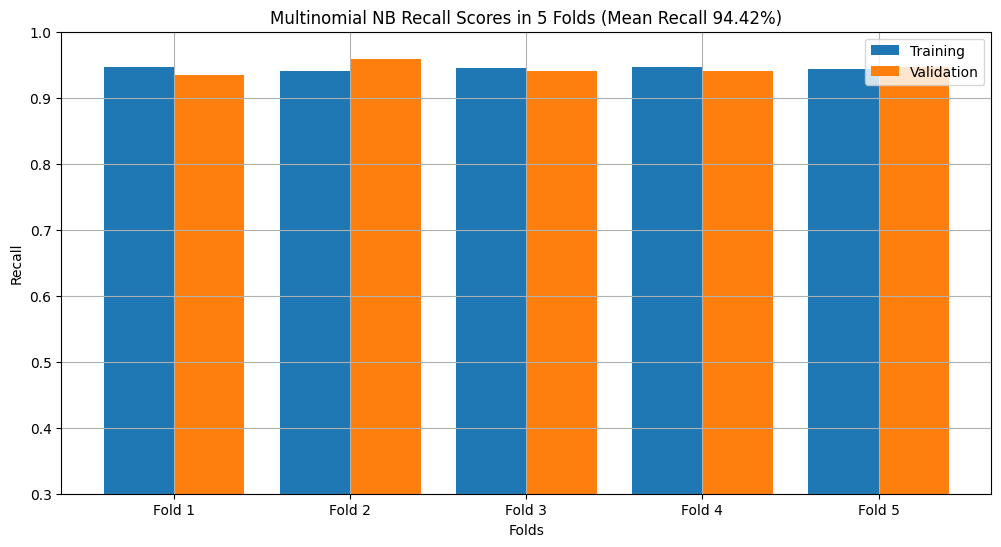

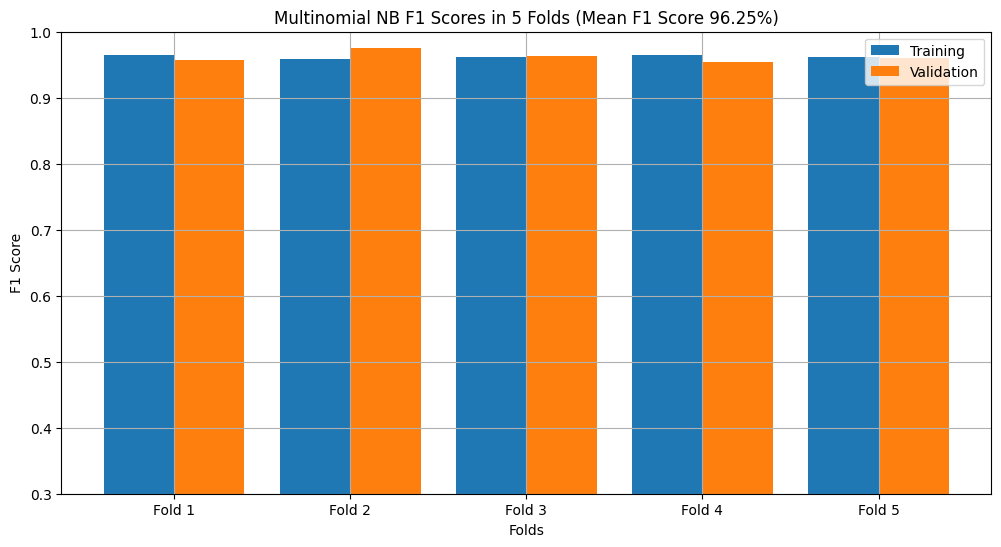

K Nearest Neighbors 

Training Accuracy scores: [0.97169144 0.97239915 0.97100424 0.97595474 0.97029703]
Mean Training Accuracy: 97.22693197436213
Training Precision scores: [0.98027314 0.97172619 0.97168405 0.97477745 0.9702381 ]
Mean Training Precision: 0.9737397857119365
Training Recall scores: [0.95988113 0.97028232 0.96735905 0.97477745 0.96735905]
Mean Training Recall: 0.9679317992425078
Training F1 scores: [0.96996997 0.97100372 0.96951673 0.97477745 0.96879643]
Mean Training F1 Score: 0.9708128596031997
Validation Accuracy scores: [0.96327684 0.96892655 0.96600567 0.95467422 0.96883853]
Mean Validation Accuracy: 96.43443606856485
Validation Precision scores: [0.97560976 0.97590361 0.95882353 0.94705882 0.96449704]
Mean Validation Precision: 0.9643785529833375
Validation Recall scores: [0.94674556 0.95857988 0.9702381  0.95833333 0.9702381 ]
Mean Validation Recall: 0.9608269935193012
Validation F1 scores: [0.96096096 0.96716418 0.96449704 0.95266272 0.96735905]
Mean Validation F

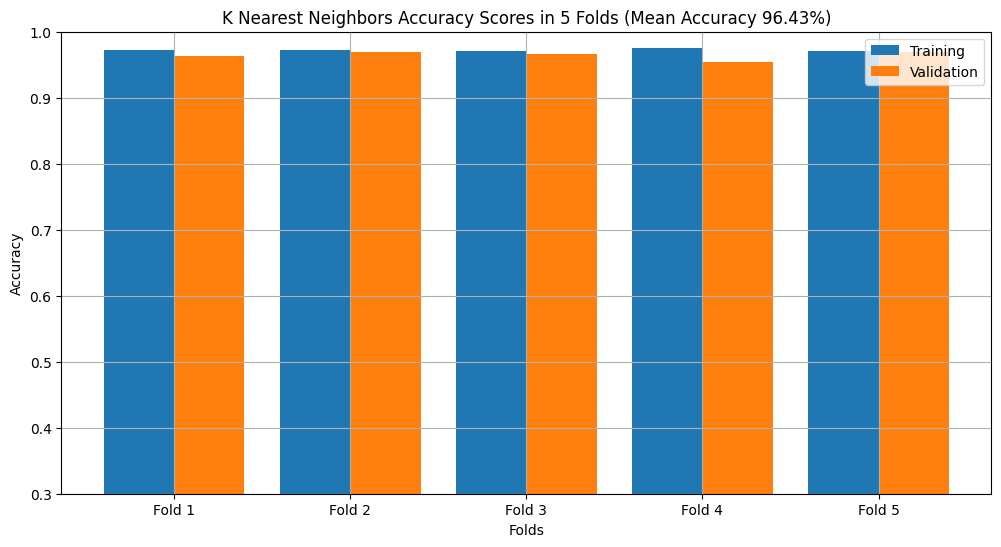

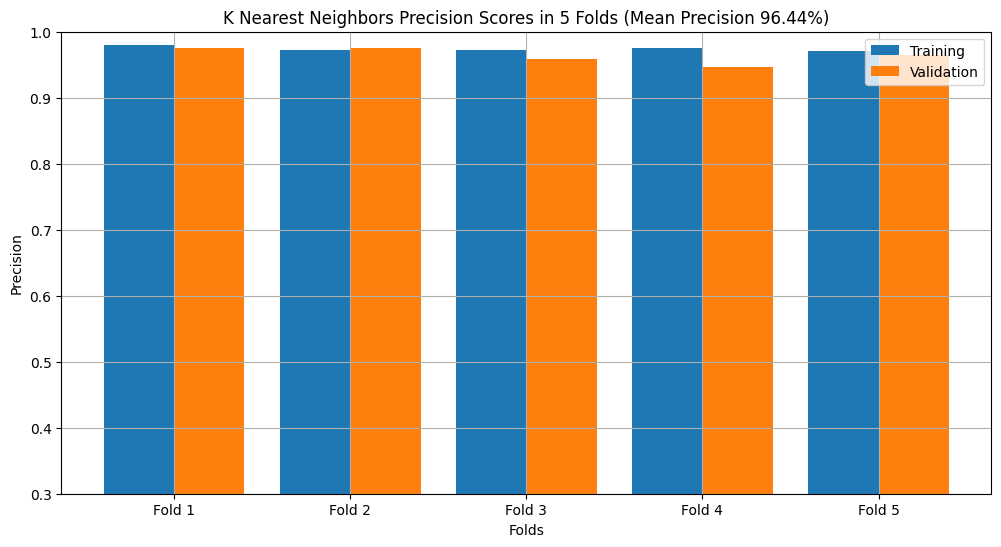

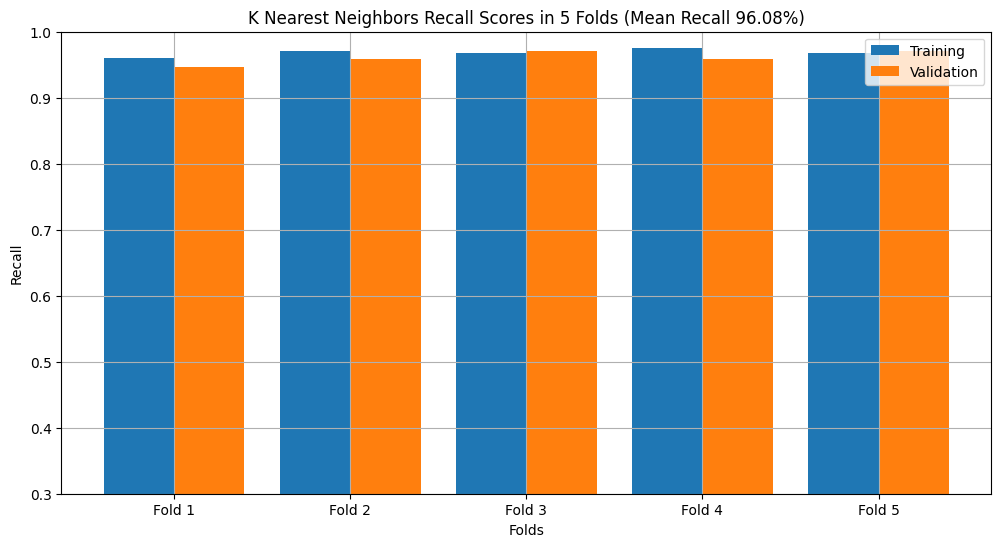

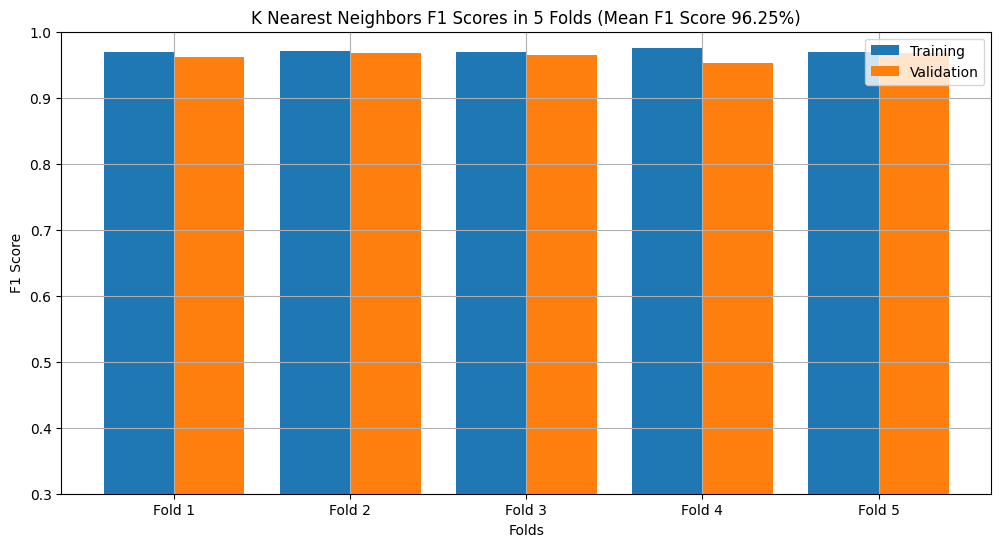

Decision Tree 

Training Accuracy scores: [1.         0.99929229 1.         0.99929279 0.99929279]
Mean Training Accuracy: 99.95755717518978
Training Precision scores: [1. 1. 1. 1. 1.]
Mean Training Precision: 1.0
Training Recall scores: [1.         0.99851412 1.         0.99851632 0.99851632]
Mean Training Recall: 0.9991093513697029
Training F1 scores: [1.         0.99925651 1.         0.99925761 0.99925761]
Mean Training F1 Score: 0.9995543449162811
Validation Accuracy scores: [0.9519774  0.96327684 0.95467422 0.95467422 0.96033994]
Mean Validation Accuracy: 95.69885245114514
Validation Precision scores: [0.94705882 0.96428571 0.94186047 0.95783133 0.96385542]
Mean Validation Precision: 0.9549783499838714
Validation Recall scores: [0.95266272 0.95857988 0.96428571 0.94642857 0.95238095]
Mean Validation Recall: 0.9548675683291068
Validation F1 scores: [0.94985251 0.96142433 0.95294118 0.95209581 0.95808383]
Mean Validation F1 Score: 0.9548795313815992


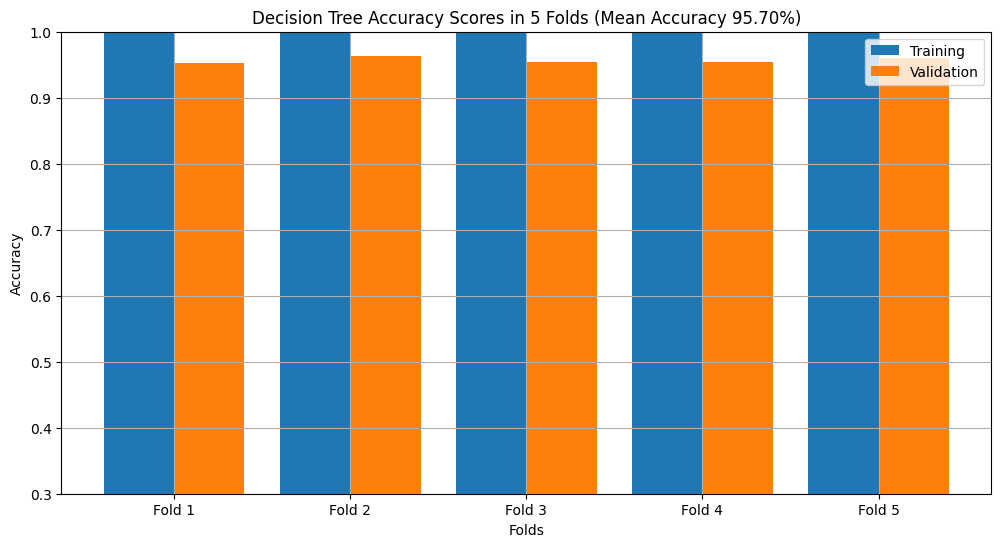

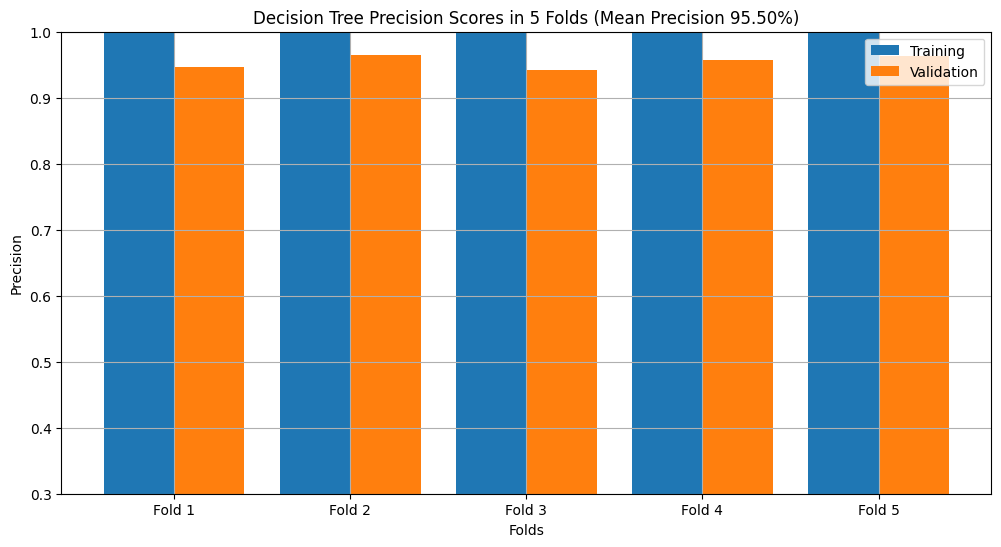

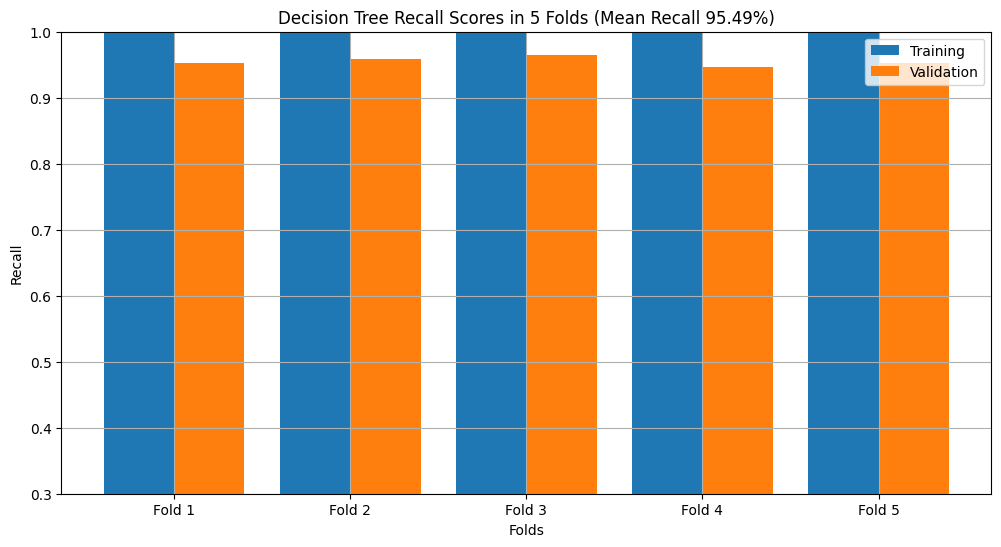

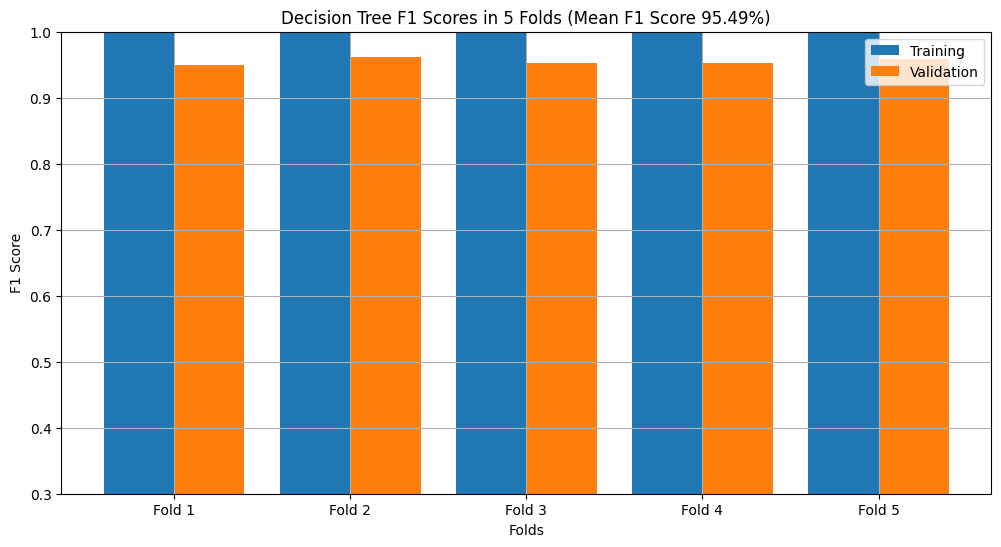

Random Forest 

Training Accuracy scores: [1.         0.99929229 1.         0.99929279 0.99929279]
Mean Training Accuracy: 99.95755717518978
Training Precision scores: [1.         1.         1.         0.99851852 0.99851852]
Mean Training Precision: 0.9994074074074074
Training Recall scores: [1.         0.99851412 1.         1.         1.        ]
Mean Training Recall: 0.999702823179792
Training F1 scores: [1.         0.99925651 1.         0.99925871 0.99925871]
Mean Training F1 Score: 0.9995547851775101
Validation Accuracy scores: [0.96327684 0.96892655 0.96033994 0.9631728  0.96883853]
Mean Validation Accuracy: 96.49109329236086
Validation Precision scores: [0.96428571 0.97590361 0.95833333 0.96407186 0.96449704]
Mean Validation Precision: 0.9654183119568845
Validation Recall scores: [0.95857988 0.95857988 0.95833333 0.95833333 0.9702381 ]
Mean Validation Recall: 0.9608129050436742
Validation F1 scores: [0.96142433 0.96716418 0.95833333 0.96119403 0.96735905]
Mean Validation F1 Score

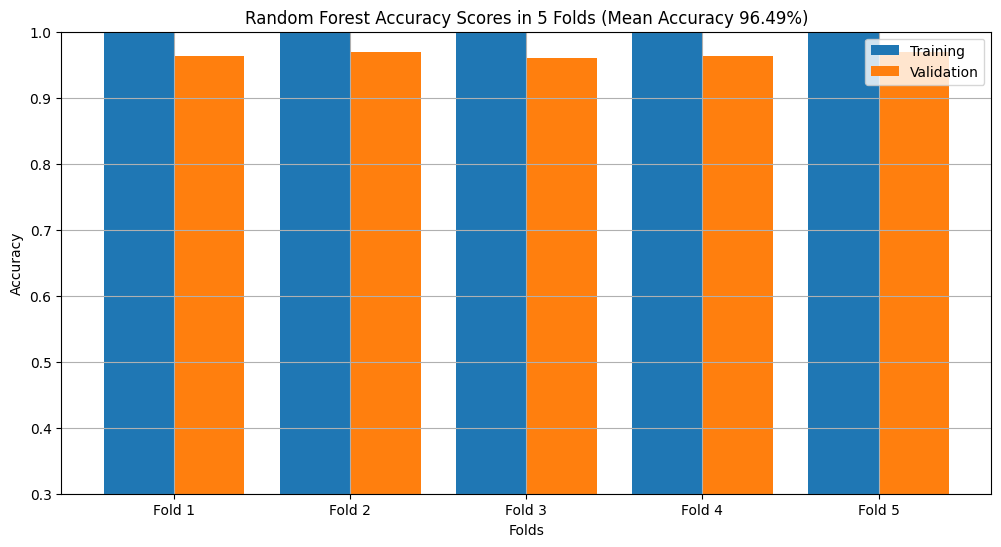

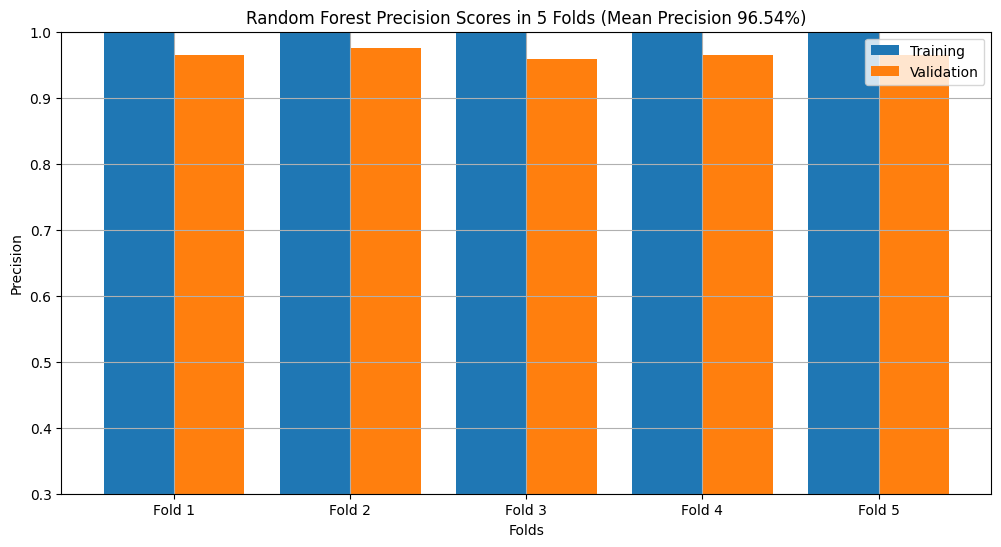

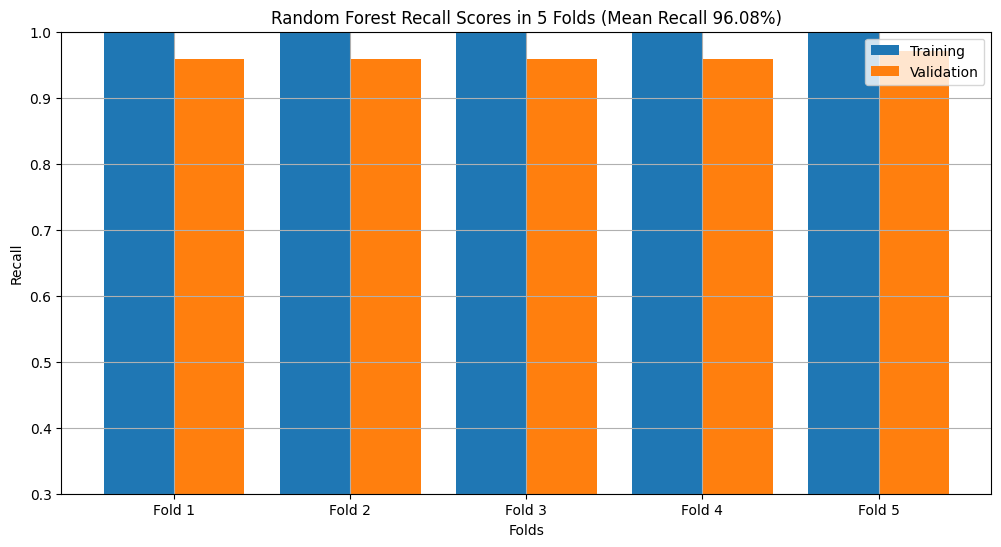

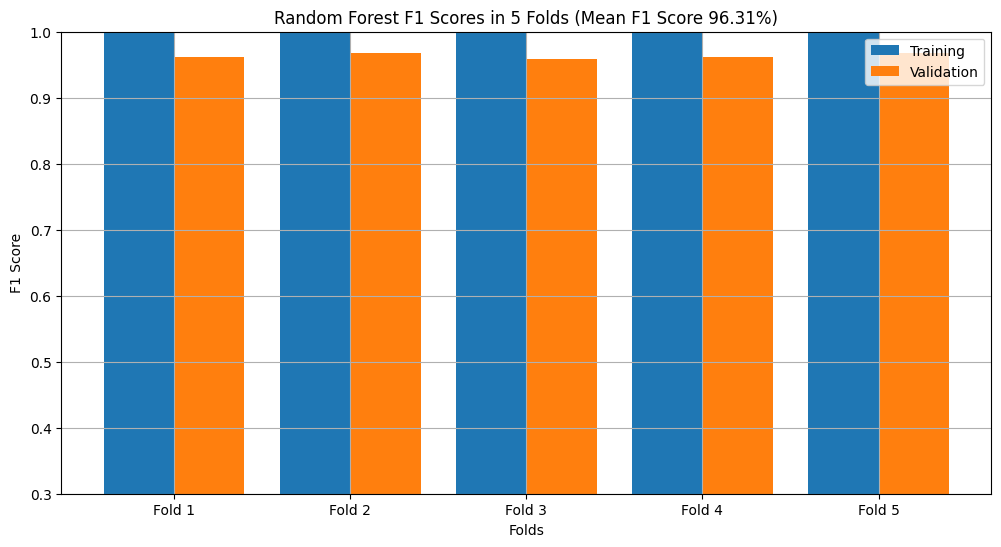

Logistic Regression 

Training Accuracy scores: [0.96815287 0.96744515 0.96958982 0.9688826  0.96676096]
Mean Training Accuracy: 96.81662797762944
Training Precision scores: [0.98012232 0.96721311 0.97443609 0.97583082 0.96444444]
Mean Training Precision: 0.9724093578586196
Training Recall scores: [0.95245171 0.96433878 0.96142433 0.95845697 0.96587537]
Mean Training Recall: 0.9605094333799233
Training F1 scores: [0.96608892 0.96577381 0.96788648 0.96706587 0.96515938]
Mean Training F1 Score: 0.9663948919869426
Validation Accuracy scores: [0.96045198 0.96892655 0.96883853 0.95467422 0.96883853]
Mean Validation Accuracy: 96.43459611721964
Validation Precision scores: [0.98136646 0.98170732 0.97575758 0.96341463 0.96449704]
Mean Validation Precision: 0.973348605604907
Validation Recall scores: [0.93491124 0.95266272 0.95833333 0.94047619 0.9702381 ]
Mean Validation Recall: 0.9513243167089321
Validation F1 scores: [0.95757576 0.96696697 0.96696697 0.95180723 0.96735905]
Mean Validation F1

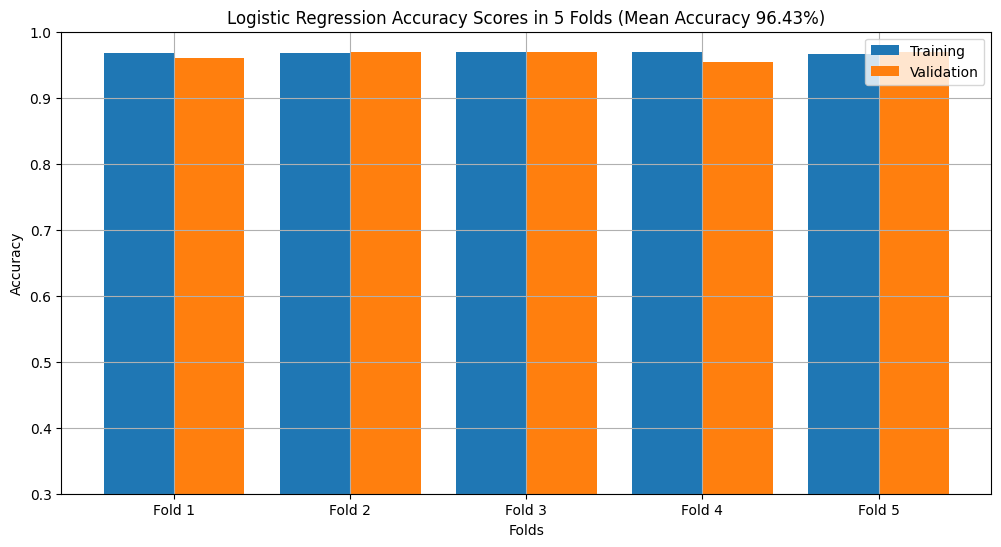

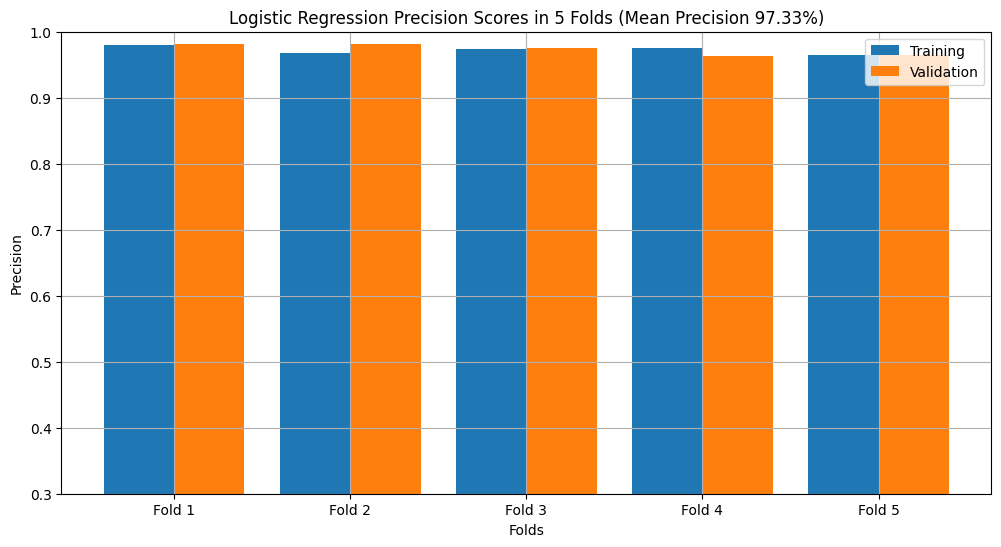

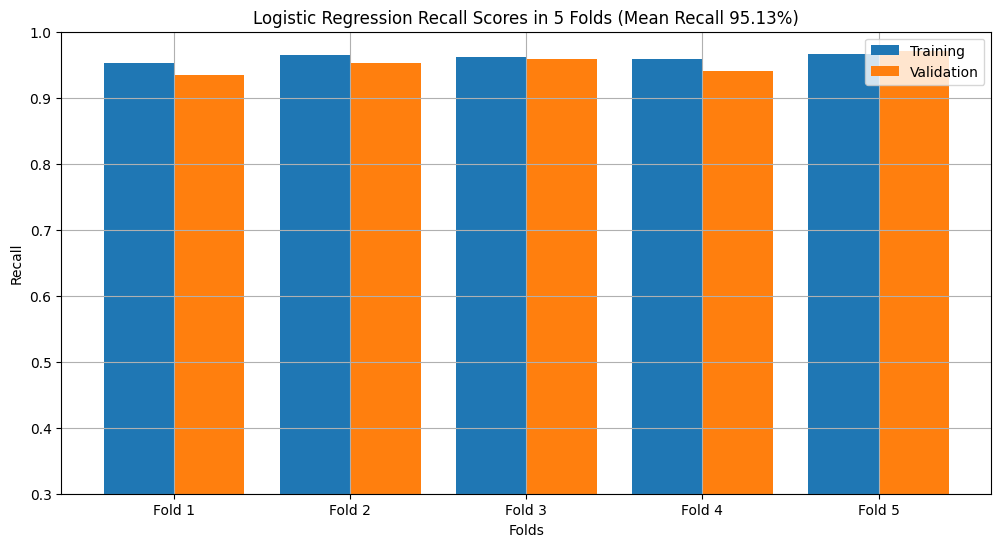

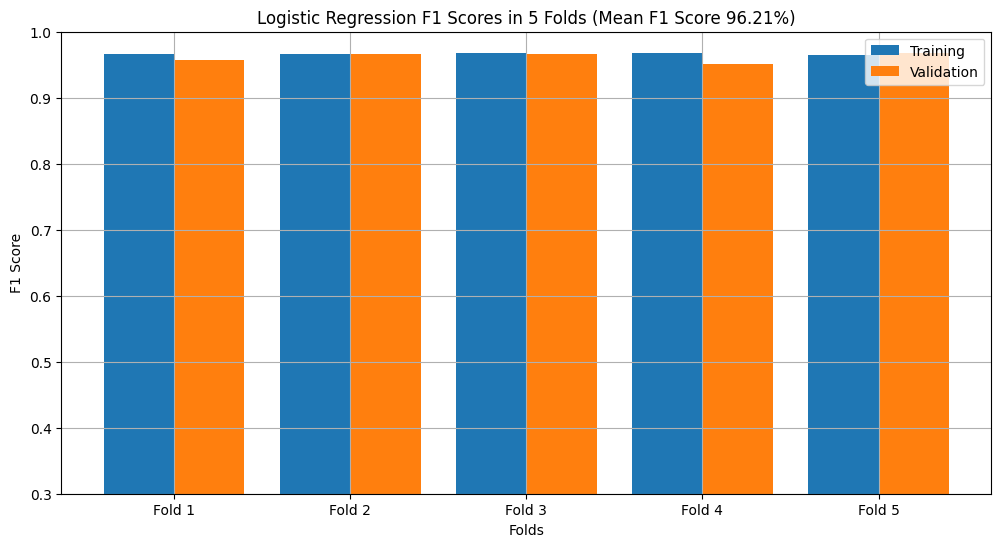

Multilayer Perceptron 

Training Accuracy scores: [0.96673744 0.96744515 0.97171146 0.97029703 0.9688826 ]
Mean Training Accuracy: 96.90147358684914
Training Precision scores: [0.97568389 0.97428139 0.9745509  0.98318043 0.97439759]
Mean Training Precision: 0.9764188398215327
Training Recall scores: [0.95393759 0.95690936 0.96587537 0.95400593 0.95994065]
Mean Training Recall: 0.9581337824789132
Training F1 scores: [0.9646882  0.96551724 0.97019374 0.96837349 0.9671151 ]
Mean Training F1 Score: 0.9671775555116648
Validation Accuracy scores: [0.96045198 0.97457627 0.96883853 0.95750708 0.97450425]
Mean Validation Accuracy: 96.71756213889023
Validation Precision scores: [0.96969697 0.99382716 0.97005988 0.96932515 0.98181818]
Mean Validation Precision: 0.9769454691245464
Validation Recall scores: [0.94674556 0.95266272 0.96428571 0.94047619 0.96428571]
Mean Validation Recall: 0.9536911806142575
Validation F1 scores: [0.95808383 0.97280967 0.96716418 0.95468278 0.97297297]
Mean Validation

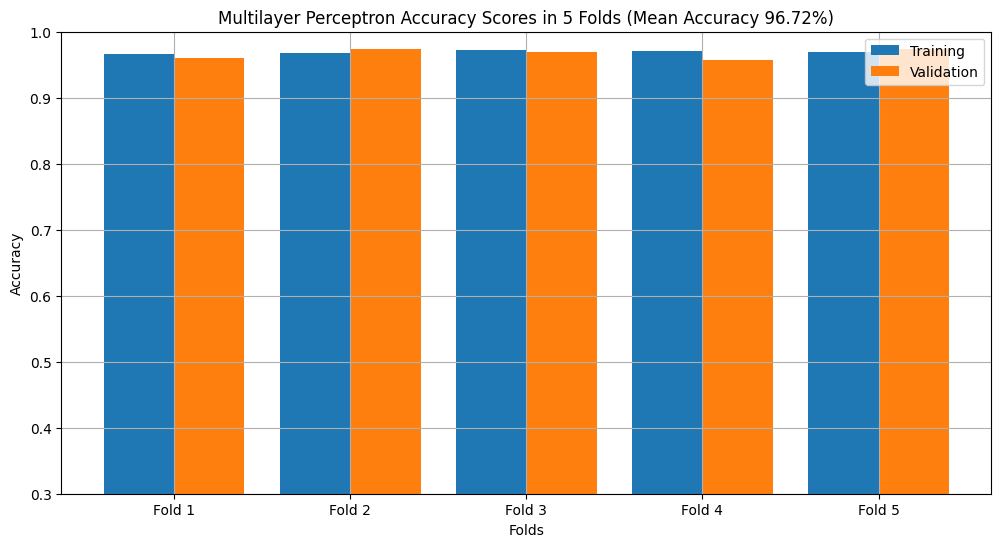

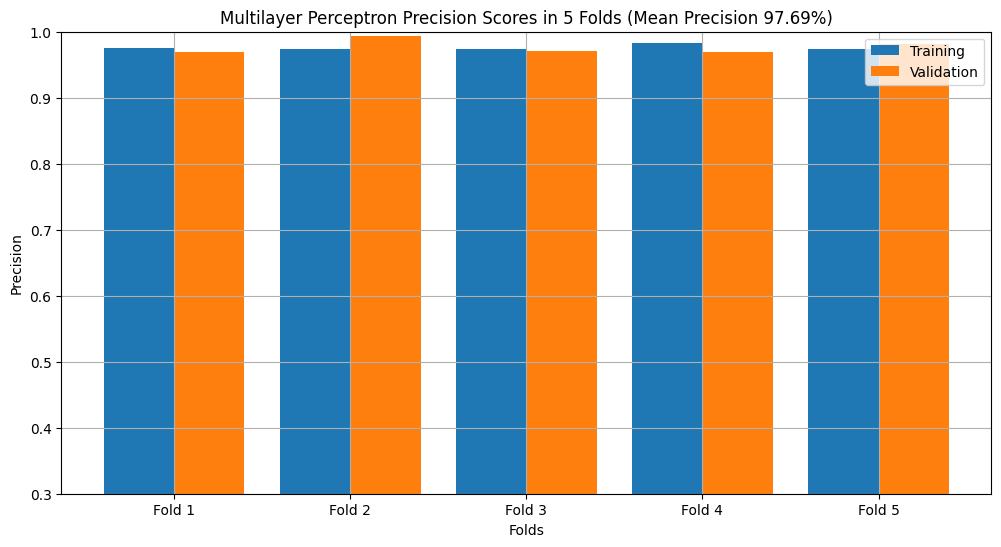

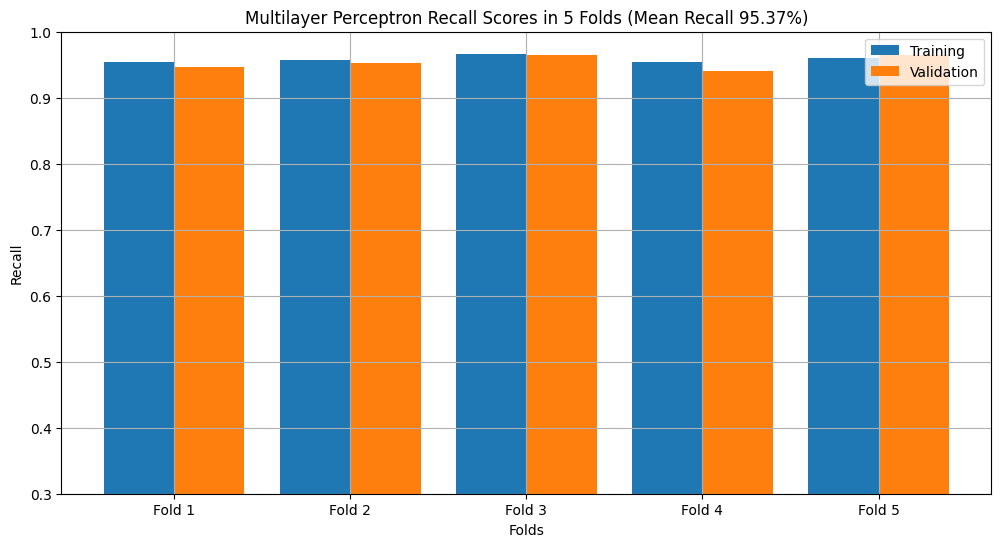

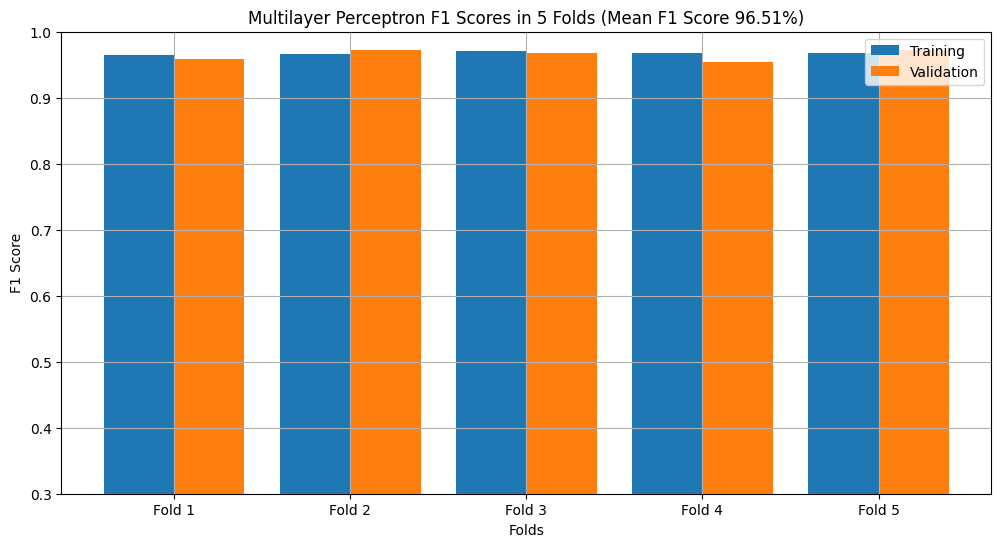

Support Vector Machines 

Training Accuracy scores: [0.96390658 0.96390658 0.96534653 0.96746818 0.95473833]
Mean Training Accuracy: 96.30732409000682
Training Precision scores: [0.98442368 0.95072464 0.97564688 0.98012232 0.91780822]
Mean Training Precision: 0.9617451473574385
Training Recall scores: [0.93907875 0.97473997 0.95103858 0.95103858 0.99406528]
Mean Training Recall: 0.9619922310748189
Training F1 scores: [0.96121673 0.96258254 0.96318557 0.96536145 0.95441595]
Mean Training F1 Score: 0.9613524487021815
Validation Accuracy scores: [0.96045198 0.97740113 0.96600567 0.95467422 0.9490085 ]
Mean Validation Accuracy: 96.1508298522751
Validation Precision scores: [0.98742138 0.97076023 0.98148148 0.96341463 0.90322581]
Mean Validation Precision: 0.9612607079290726
Validation Recall scores: [0.92899408 0.98224852 0.94642857 0.94047619 1.        ]
Mean Validation Recall: 0.9596294730910115
Validation F1 scores: [0.95731707 0.97647059 0.96363636 0.95180723 0.94915254]
Mean Validatio

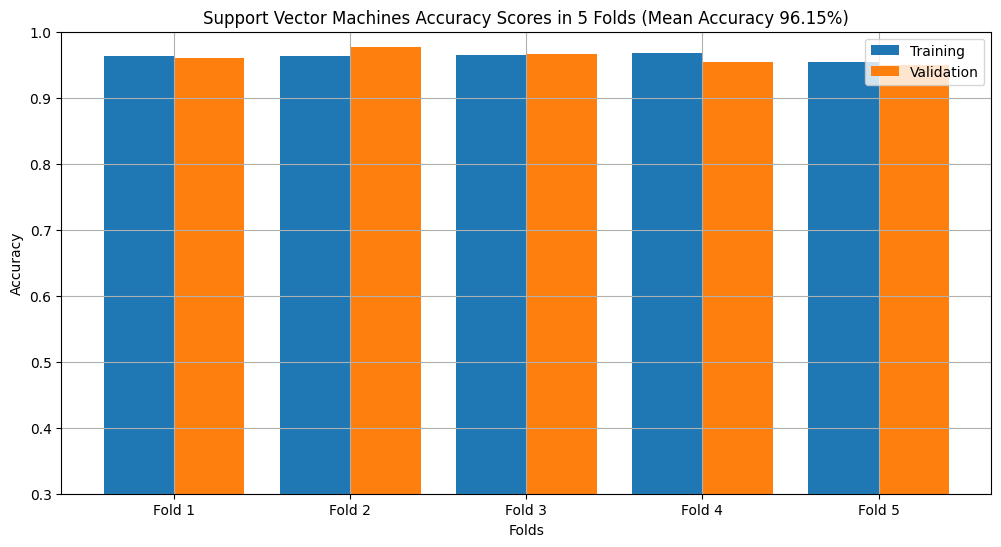

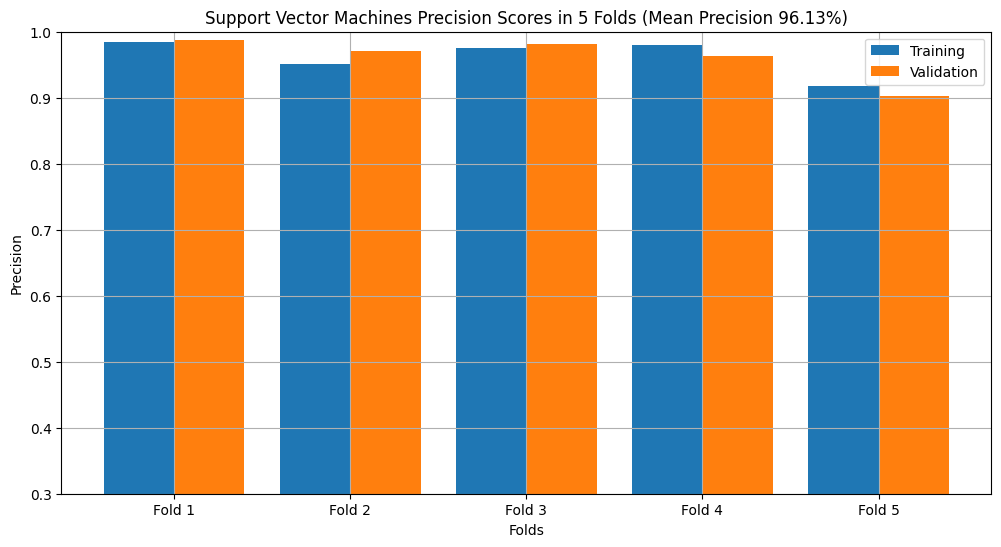

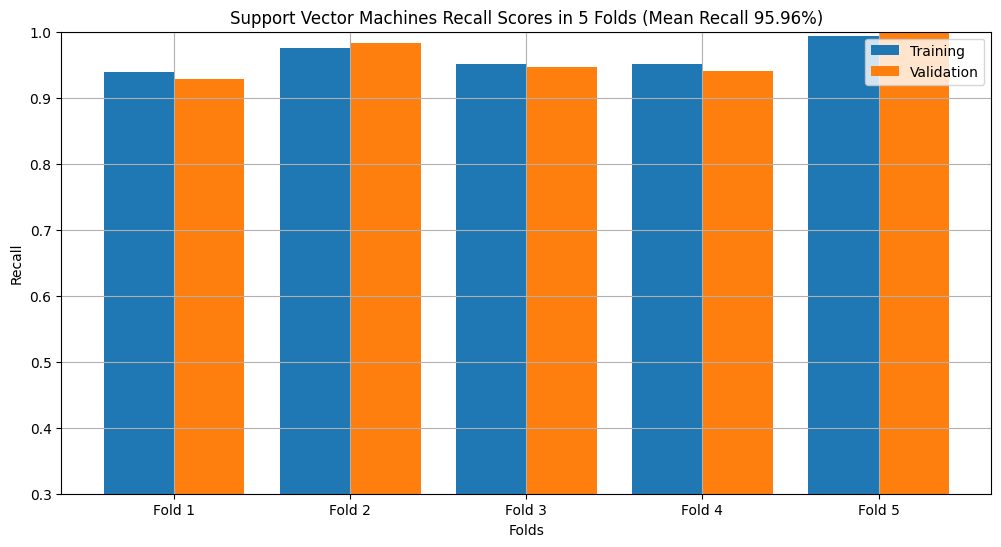

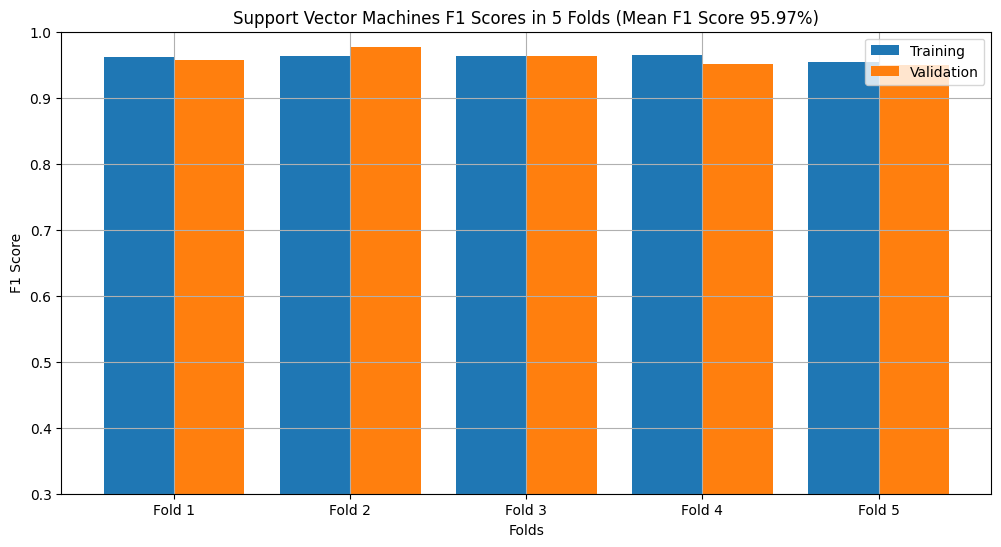

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def cross_validation(model, train_x, train_y, cv=5):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(
        estimator=model,
        X=train_x,
        y=train_y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
      
    training_result = {
        "Training Accuracy scores": results['train_accuracy'],
        "Mean Training Accuracy": results['train_accuracy'].mean()*100,
        "Training Precision scores": results['train_precision'],
        "Mean Training Precision": results['train_precision'].mean(),
        "Training Recall scores": results['train_recall'],
        "Mean Training Recall": results['train_recall'].mean(),
        "Training F1 scores": results['train_f1'],
        "Mean Training F1 Score": results['train_f1'].mean(),
        "Validation Accuracy scores": results['test_accuracy'],
        "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
        "Validation Precision scores": results['test_precision'],
        "Mean Validation Precision": results['test_precision'].mean(),
        "Validation Recall scores": results['test_recall'],
        "Mean Validation Recall": results['test_recall'].mean(),
        "Validation F1 scores": results['test_f1'],
        "Mean Validation F1 Score": results['test_f1'].mean()
    }

    return training_result

def plot_result(model_name, ylabel, desc, training_data, validation_data, mean_data):
    plt.figure(figsize=(12,6))

    labels = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
    x_axis = np.arange(len(labels))

    ax = plt.gca()

    plt.bar(x_axis - 0.2, training_data, 0.4, label='Training')
    plt.bar(x_axis + 0.2, validation_data, 0.4, label='Validation')
    
    plt.ylim(0.3, 1)
    plt.title(F"{model_name} {desc} (Mean {ylabel} {mean_data:.2%})")
    plt.xticks(x_axis, labels)
    plt.xlabel("Folds")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    
    plt.show()

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000),
    "Support Vector Machines" : SVC(),
}

for model_name, model in models.items():
    model_training_result = cross_validation(model, x, encoded_y, 5)

    print(model_name, "\n")
    for key in model_training_result:
        value = model_training_result[key]
        print(F"{key}: {value}")

    plot_result(
        model_name,
        "Accuracy",
        "Accuracy Scores in 5 Folds",
        model_training_result["Training Accuracy scores"],
        model_training_result["Validation Accuracy scores"],
        model_training_result["Mean Validation Accuracy"]/100
    )

    plot_result(
        model_name,
        "Precision",
        "Precision Scores in 5 Folds",
        model_training_result["Training Precision scores"],
        model_training_result["Validation Precision scores"],
        model_training_result["Mean Validation Precision"]
    )

    plot_result(
        model_name,
        "Recall",
        "Recall Scores in 5 Folds",
        model_training_result["Training Recall scores"],
        model_training_result["Validation Recall scores"],
        model_training_result["Mean Validation Recall"]
    )

    plot_result(
        model_name,
        "F1 Score",
        "F1 Scores in 5 Folds",
        model_training_result["Training F1 scores"],
        model_training_result["Validation F1 scores"],
        model_training_result["Mean Validation F1 Score"]
    )

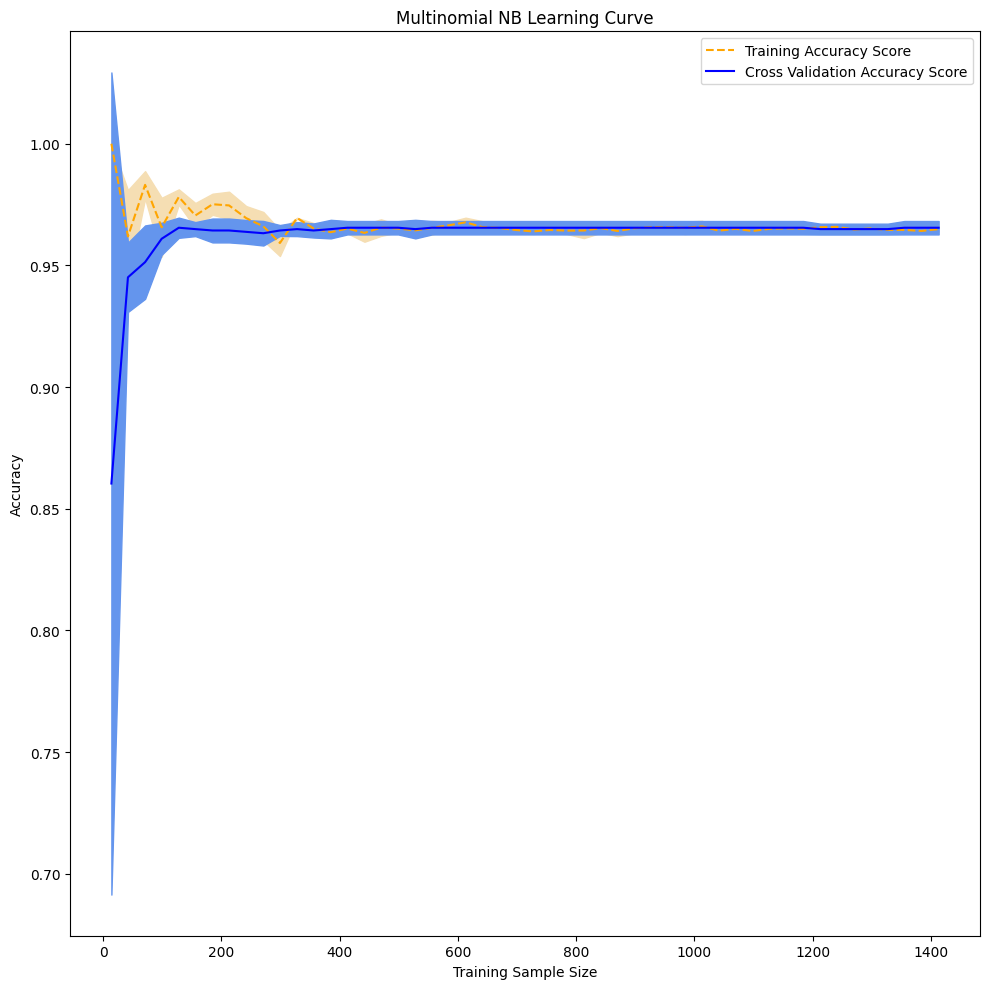

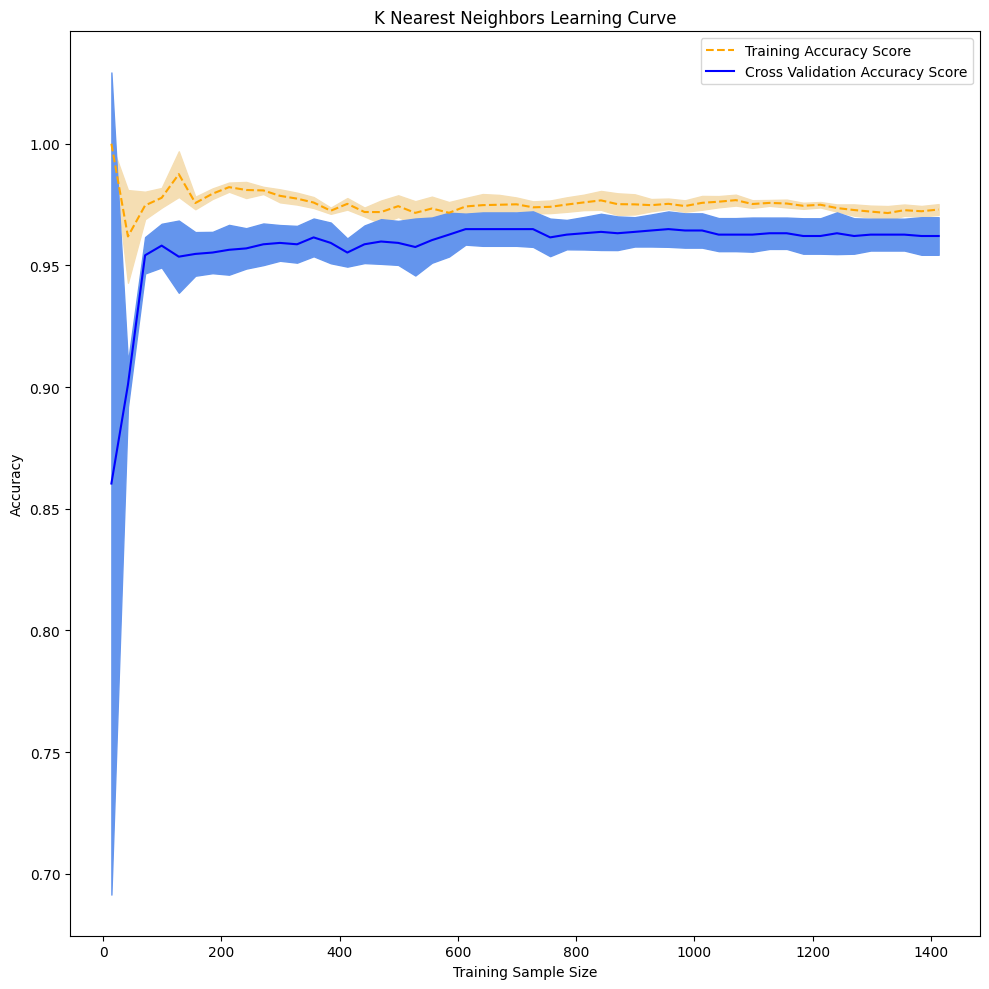

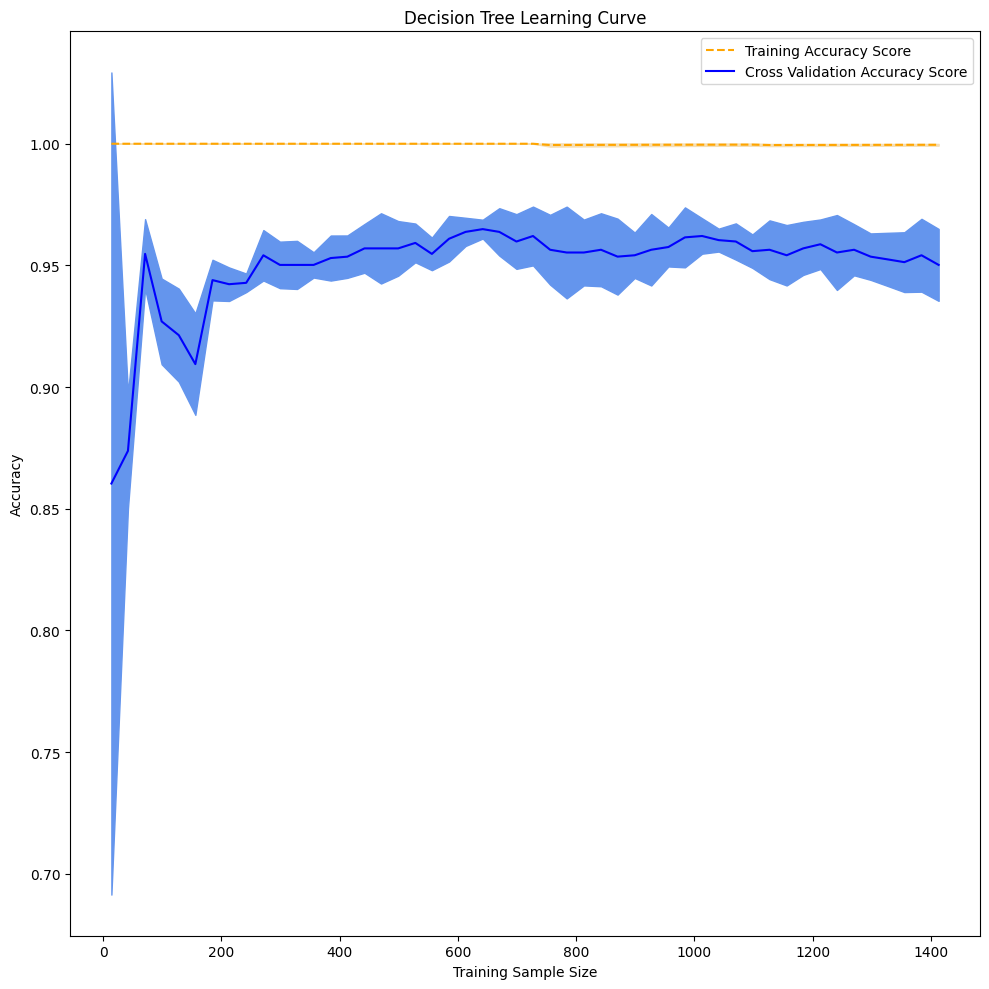

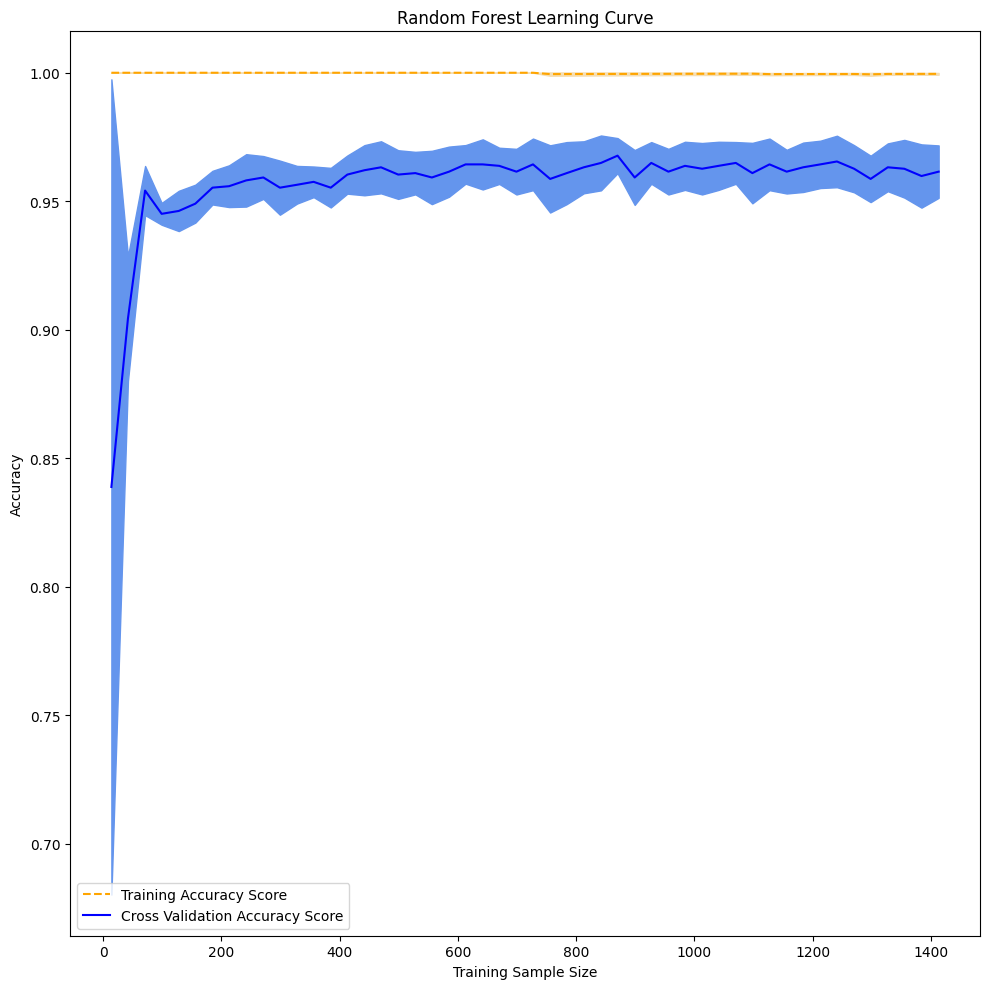

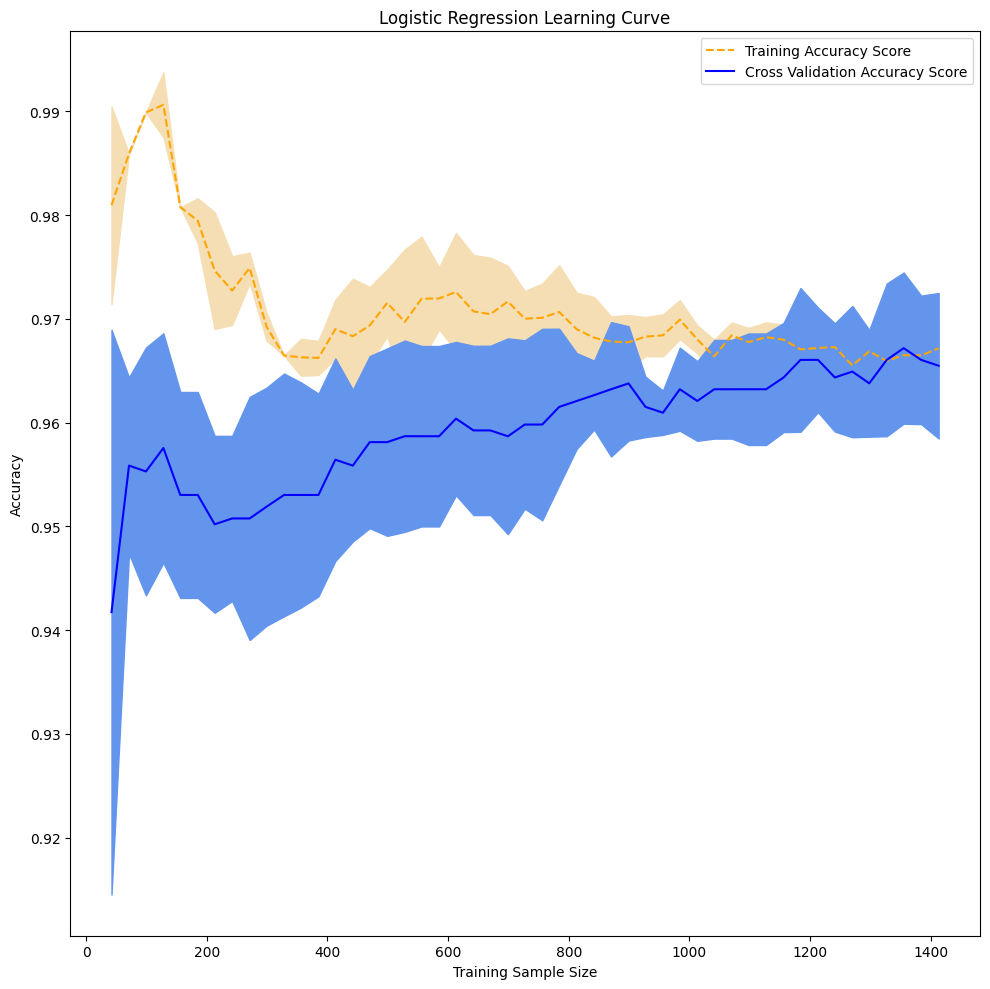

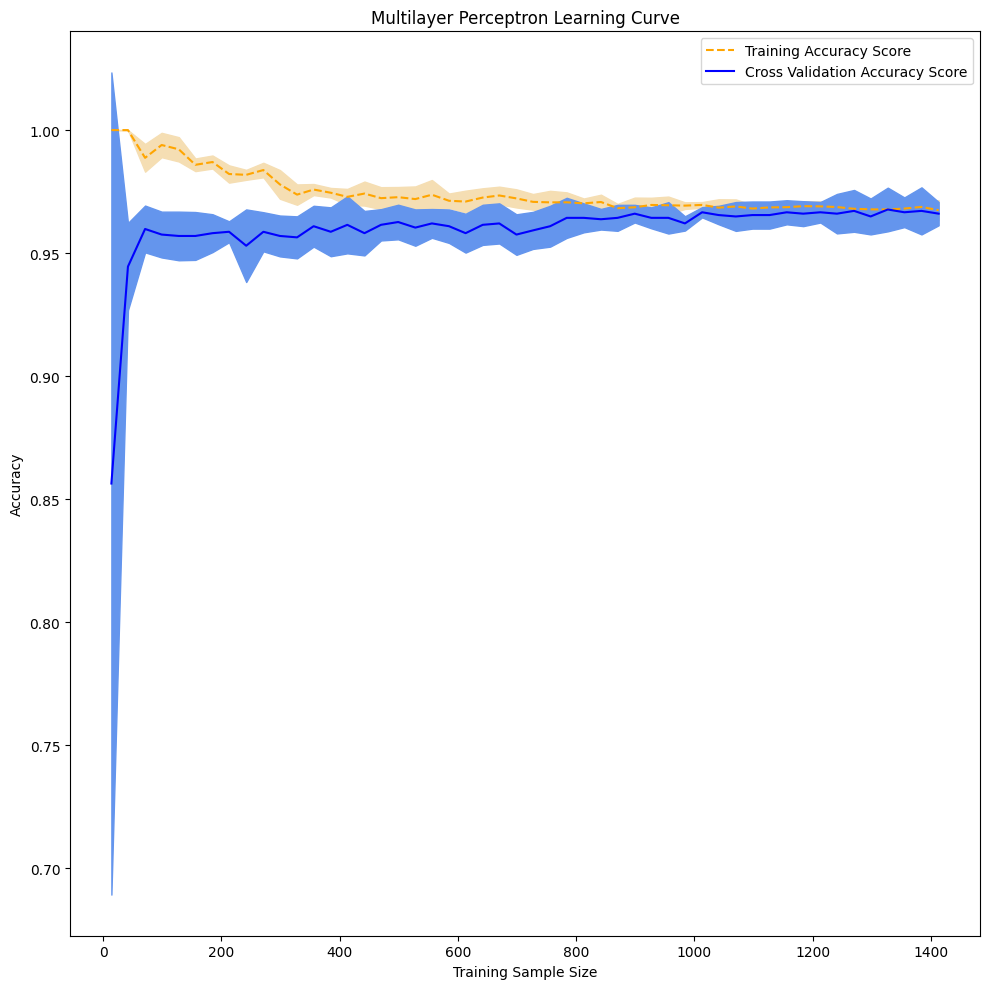

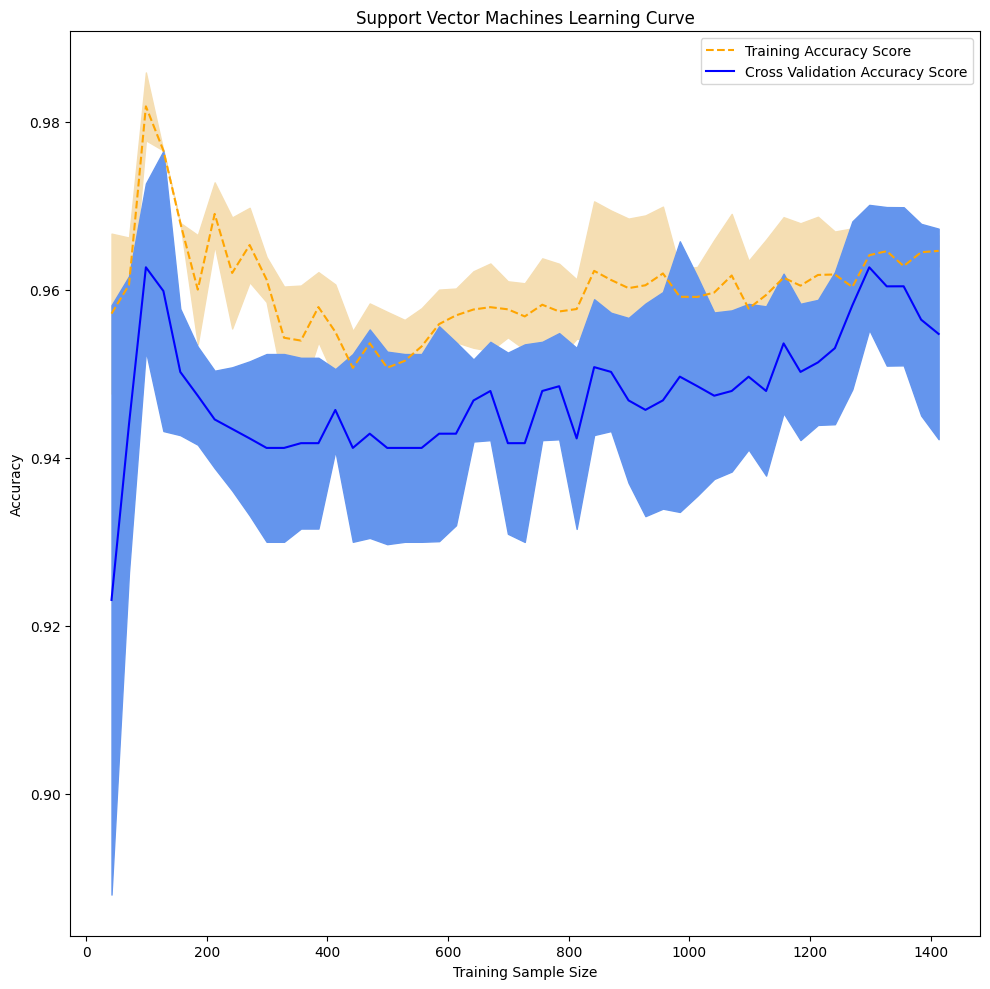

In [3]:
from sklearn.model_selection import learning_curve

random.shuffle(training_dataset)

feature_list = [tup[0] for tup in training_dataset]
x = []
for dictionary in feature_list:
    values = [*dictionary.values()]
    x.append(values)

y = [tup[1] for tup in training_dataset]

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)

models = {
    "Multinomial NB": MultinomialNB(),
    "K Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000),
    "Support Vector Machines" : SVC(),
}

for model_name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, x, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color='orange',  label='Training Accuracy Score')
    plt.plot(train_sizes, test_mean, color='blue', label='Cross Validation Accuracy Score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='wheat')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='cornflowerblue')

    plt.title(F"{model_name} Learning Curve")
    plt.xlabel("Training Sample Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.tight_layout()

    plt.show()